In [1]:
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

## Read data from Train,Test and Truth 

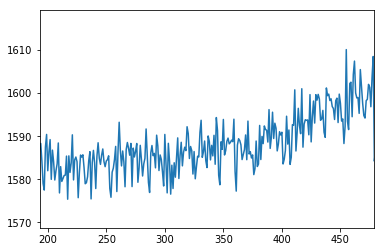

In [17]:


# read training data 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
#print(train_df)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

#plt.xlim(193,479) #2
#plt.xlim(480,658) #3


plt.xlim(193,479) #2
plt.plot(train_df['s3'])

In [4]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [18]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Preprocessing Generate labels for the training data which are Remaining Useful Life (RUL), label1 and label2

In [19]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()# generate label columns for training data


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [8]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [12]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [11]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index) #normalizes every column except ones which need not be.
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df) #joins normalized columns with cols_normalize
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,36.832409,625.500000,-100.0,-518.67,-192.971331,-34.243064,-23.328504,-14.62,...,-3511.263841,-41.798988,-30.842382,-0.03,-32.305556,-2388.0,-100.0,-29.133225,-30.699208,0.00000
1,1,2,20.317677,208.833333,-100.0,-518.67,-193.090180,-34.241562,-23.329299,-14.62,...,-3511.198962,-41.798613,-31.211008,-0.03,-32.298611,-2388.0,-100.0,-29.037077,-30.664696,0.00277
2,1,3,30.226516,486.611111,-100.0,-518.67,-193.022137,-34.242280,-23.327612,-14.62,...,-3511.263841,-41.798867,-30.266495,-0.03,-32.298611,-2388.0,-100.0,-29.001022,-30.617029,0.00554
3,1,4,43.108006,417.166667,-100.0,-518.67,-193.023951,-34.243620,-23.326165,-14.62,...,-3511.220588,-41.798792,-31.042240,-0.03,-32.312500,-2388.0,-100.0,-29.049096,-30.698826,0.00831
4,1,5,33.859757,417.166667,-100.0,-518.67,-193.017601,-34.242161,-23.327447,-14.62,...,-3511.263841,-41.798881,-30.873471,-0.03,-32.319444,-2388.0,-100.0,-29.055105,-30.623893,0.01108


In [13]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
print(truth_df)
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

      0
0   112
1    98
2    69
3    82
4    91
5    93
6    91
7    95
8   111
9    96
10   97
11  124
12   95
13  107
14   83
15   84
16   50
17   28
18   87
19   16
20   57
21  111
22  113
23   20
24  145
25  119
26   66
27   97
28   90
29  115
..  ...
70  118
71   50
72  131
73  126
74  113
75   10
76   34
77  107
78   63
79   90
80    8
81    9
82  137
83   58
84  118
85   89
86  116
87  115
88  136
89   28
90   38
91   20
92   85
93   55
94  128
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]


In [14]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head(50)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,36.832409,625.500000,-100.0,-518.67,-192.971331,-34.243064,-23.328504,-14.62,...,-41.798988,-30.842382,-0.03,-32.305556,-2388.0,-100.0,-29.133225,-30.699208,0.000000,142
1,1,2,20.317677,208.833333,-100.0,-518.67,-193.090180,-34.241562,-23.329299,-14.62,...,-41.798613,-31.211008,-0.03,-32.298611,-2388.0,-100.0,-29.037077,-30.664696,0.002770,141
2,1,3,30.226516,486.611111,-100.0,-518.67,-193.022137,-34.242280,-23.327612,-14.62,...,-41.798867,-30.266495,-0.03,-32.298611,-2388.0,-100.0,-29.001022,-30.617029,0.005540,140
3,1,4,43.108006,417.166667,-100.0,-518.67,-193.023951,-34.243620,-23.326165,-14.62,...,-41.798792,-31.042240,-0.03,-32.312500,-2388.0,-100.0,-29.049096,-30.698826,0.008310,139
4,1,5,33.859757,417.166667,-100.0,-518.67,-193.017601,-34.242161,-23.327447,-14.62,...,-41.798881,-30.873471,-0.03,-32.319444,-2388.0,-100.0,-29.055105,-30.623893,0.011080,138
5,1,6,33.199168,625.500000,-100.0,-518.67,-193.053890,-34.245996,-23.329382,-14.62,...,-41.798937,-30.567022,-0.03,-32.305556,-2388.0,-100.0,-29.103179,-30.750307,0.013850,137
6,1,7,29.235632,556.055556,-100.0,-518.67,-193.053890,-34.243991,-23.326615,-14.62,...,-41.798737,-31.046681,-0.03,-32.312500,-2388.0,-100.0,-29.139234,-30.657832,0.016620,136
7,1,8,31.217400,417.166667,-100.0,-518.67,-193.014879,-34.245155,-23.327741,-14.62,...,-41.798978,-30.604033,-0.03,-32.298611,-2388.0,-100.0,-29.019049,-30.796640,0.019391,135
8,1,9,17.345026,417.166667,-100.0,-518.67,-193.074757,-34.239262,-23.324495,-14.62,...,-41.798759,-30.396773,-0.03,-32.312500,-2388.0,-100.0,-28.989003,-30.549341,0.022161,134
9,1,10,20.978267,347.722222,-100.0,-518.67,-193.057519,-34.243083,-23.328382,-14.62,...,-41.798761,-30.781684,-0.03,-32.312500,-2388.0,-100.0,-29.127216,-30.683001,0.024931,133


In [15]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head(50)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,36.832409,625.500000,-100.0,-518.67,-192.971331,-34.243064,-23.328504,-14.62,...,-0.03,-32.305556,-2388.0,-100.0,-29.133225,-30.699208,0.000000,142,0,0
1,1,2,20.317677,208.833333,-100.0,-518.67,-193.090180,-34.241562,-23.329299,-14.62,...,-0.03,-32.298611,-2388.0,-100.0,-29.037077,-30.664696,0.002770,141,0,0
2,1,3,30.226516,486.611111,-100.0,-518.67,-193.022137,-34.242280,-23.327612,-14.62,...,-0.03,-32.298611,-2388.0,-100.0,-29.001022,-30.617029,0.005540,140,0,0
3,1,4,43.108006,417.166667,-100.0,-518.67,-193.023951,-34.243620,-23.326165,-14.62,...,-0.03,-32.312500,-2388.0,-100.0,-29.049096,-30.698826,0.008310,139,0,0
4,1,5,33.859757,417.166667,-100.0,-518.67,-193.017601,-34.242161,-23.327447,-14.62,...,-0.03,-32.319444,-2388.0,-100.0,-29.055105,-30.623893,0.011080,138,0,0
5,1,6,33.199168,625.500000,-100.0,-518.67,-193.053890,-34.245996,-23.329382,-14.62,...,-0.03,-32.305556,-2388.0,-100.0,-29.103179,-30.750307,0.013850,137,0,0
6,1,7,29.235632,556.055556,-100.0,-518.67,-193.053890,-34.243991,-23.326615,-14.62,...,-0.03,-32.312500,-2388.0,-100.0,-29.139234,-30.657832,0.016620,136,0,0
7,1,8,31.217400,417.166667,-100.0,-518.67,-193.014879,-34.245155,-23.327741,-14.62,...,-0.03,-32.298611,-2388.0,-100.0,-29.019049,-30.796640,0.019391,135,0,0
8,1,9,17.345026,417.166667,-100.0,-518.67,-193.074757,-34.239262,-23.324495,-14.62,...,-0.03,-32.312500,-2388.0,-100.0,-28.989003,-30.549341,0.022161,134,0,0
9,1,10,20.978267,347.722222,-100.0,-518.67,-193.057519,-34.243083,-23.328382,-14.62,...,-0.03,-32.312500,-2388.0,-100.0,-29.127216,-30.683001,0.024931,133,0,0
